**Импорт библиотек**

In [ ]:
from tensorflow.keras.models import Model, Sequential
 
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, MaxPooling2D, Conv2D, BatchNormalization, Dropout, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras.layers import LeakyReLU, AveragePooling2D, Activation
from tensorflow.keras.datasets import mnist, fashion_mnist
 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
 
import os
from google.colab import drive
import time
import pickle
import PIL

In [ ]:
import os, datetime
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate, ZeroPadding2D
from keras.layers import add
from keras.optimizers import Adam
from matplotlib import pyplot as plt

# Работа с данными

In [ ]:
# 1) Импортирование данных и изменение размера
import os
import cv2

main_dir = 'drive/My Drive/Diplom/Base/TestBasePokemons'

src = f'{main_dir}/data'
dst = f'{main_dir}/resizedData'

# os.mkdir(dst)

for each in os.listdir(src):
  img = cv2.imread(os.path.join(src, each))
  img = cv2.resize(img, (64, 64))
  cv2.imwrite(os.path.join(dst,each), img)

In [ ]:
# 2) Изменение цветности заднего фона изображений
main_dir = 'drive/My Drive/Diplom/Base/TestBasePokemons'
src = f'{main_dir}/resizedData'
dst = f'{main_dir}/resized_black'

for each in os.listdir(src):
  png = Image.open(os.path.join(src, each))
  if png.mode == 'RGBA':
    png.load()
    bg = Image.new("RGB", png.size, (0, 0, 0))
    bg.paste(png, mask=png.split()[3])
    bg.save(os.path.join(dst, each.split('.')[0] + '.jpg'), 'JPEG')
  else:
    png.convert('RGB')
    png.save(os.path.join(dst, each.split('.')[0] + '.jpg'), 'JPEG')

In [ ]:
# 3) Cоздание выборки
 
def work_on_data():
  main_dir = 'drive/My Drive/Diplom/Base/TestBasePokemons'
  pokemon_dir = f'{main_dir}/resized_black/'
 
  xTrain = []
 
  arr = os.listdir(pokemon_dir)
 
  for each in arr:
    xpath = os.path.join(pokemon_dir, each)
    img = np.asarray(image.load_img(xpath))
    xTrain.append(np.asarray(img))
 
  xTrain = np.array(xTrain)
 
  return xTrain

In [ ]:
xTrain = work_on_data()
print(xTrain[0].shape)

(64, 64, 3)


In [ ]:
!unzip '/content/drive/MyDrive/Diplom/Base/directory.zip'

Streaming output truncated to the last 5000 lines.
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0092_111413.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0093_110990.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0098_111073.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0104_113105.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0106_111564.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0108_112963.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0111_112968.jpg  
  inflating: directory/birds/CUB_200_2011/images/118.House

In [ ]:
### Функции для загрузки датасета ###

def load_class_ids(class_info_file_path):
  """
  Грузим id класса с файла class_info.pickle
  """
  with open(class_info_file_path, 'rb') as f:
    class_ids = pickle.load(f, encoding='latin1')
  return class_ids


def load_embeddings(embeddings_file_path):
  """
  Загружаем эмбединги для текста
  """
  with open(embeddings_file_path, 'rb') as f:
    embeddings = pickle.load(f, encoding='latin1')
    embeddings = np.array(embeddings)
    print('embeddings: ', embeddings.shape)
  return embeddings


def load_filenames(filenames_file_path):
  """
  Грузим filenames.pickle и возвращаем все имена файлов
  """
  with open(filenames_file_path, 'rb') as f:
    filenames = pickle.load(f, encoding='latin1')
  return filenames


def load_bounding_boxes(dataset_dir):
  """
  Грузим bounding boxes и возвращаем словарь с именем файла и соответствующем ему bouding box
  """

  # Папки
  bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
  file_paths_path = os.path.join(dataset_dir, 'images.txt')

  # Прочитаем bounding_boxes.txt и images.txt
  df_bounding_boxes = pd.read_csv(bounding_boxes_path, delim_whitespace=True, header=None).astype(int)
  df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

  # Создаем список имен файлов
  file_names = df_file_names[1].tolist()

  # Создаем словарь с именами файлов и bounding boxes
  filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

  # Определяем bounding box к своему изображению
  for i in range(0, len(file_names)):
    # Получаем bounding box
    bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
    key = file_names[i][:-4]
    filename_boundingbox_dict[key] = bounding_box

  return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
  """
  Загружаем и изменяем размеры изображений
  """
  img = Image.open(img_path).convert('RGB')
  width, height = img.size 
  if bbox is not None:
    R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
    center_x = int((2 * bbox[0] + bbox[2]) / 2)
    center_y = int((2 * bbox[1] + bbox[3]) / 2)
    y1 = np.maximum(0, center_y - R)
    y2 = np.minimum(height, center_y + R)
    x1 = np.maximum(0, center_x - R)
    x2 = np.minimum(width, center_x + R)
    img = img.crop([x1, y1, x2, y2])
  img = img.resize(image_size, PIL.Image.BILINEAR)
  return img




def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
  """
  Полность загружаем датасет, используя предыдущие функции
  """
  filenames = load_filenames(filenames_file_path)
  class_ids = load_class_ids(class_info_file_path)
  bounding_boxes = load_bounding_boxes(cub_dataset_dir)
  all_embeddings = load_embeddings(embeddings_file_path)

  X, y, embeddings = [], [], []

  print("Embeddings shape:", all_embeddings.shape)

  for index, filename in enumerate(filenames):
    bounding_box = bounding_boxes[filename]

    try:
      # Грузим изображения
      img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
      img = get_img(img_name, bounding_box, image_size)

      all_embeddings1 = all_embeddings[index, :, :]

      embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
      embedding = all_embeddings1[embedding_ix, :]

      X.append(np.array(img))
      y.append(class_ids[index])
      embeddings.append(embedding)
    except Exception as e:
      print(e)

  X = np.array(X)
  y = np.array(y)
  embeddings = np.array(embeddings)
  return X, y, embeddings

In [ ]:
### Создание последовательности обучения, определение гиперпараметров и обучение Первой Стадии StackGAN ### 

# Определяем параметры

data_dir = '/content/directory/birds'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
# image_size = 64
# batch_size = 64
# z_dim = 100
# stage1_generator_lr = 2e-4
# stage1_discriminator_lr = 2e-4
# stage1_lr_decay_step = 600
# epochs = 1000
# condition_dim = 128

embeddings_file_path_train = train_dir + '/char-CNN-RNN-embeddings.pickle'
embeddings_file_path_test = test_dir + '/char-CNN-RNN-embeddings.pickle'

filenames_file_path_train = train_dir + '/filenames.pickle'
filenames_file_path_test = test_dir + '/filenames.pickle'

class_info_file_path_train = train_dir + '/class_info.pickle'
class_info_file_path_test = test_dir + '/class_info.pickle'

cub_dataset_dir = data_dir + '/CUB_200_2011'

In [ ]:
X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                  class_info_file_path=class_info_file_path_train,
                                                  cub_dataset_dir=cub_dataset_dir,
                                                  embeddings_file_path=embeddings_file_path_train,
                                                  image_size=(64, 64))

X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                  class_info_file_path=class_info_file_path_test,
                                                  cub_dataset_dir=cub_dataset_dir,
                                                  embeddings_file_path=embeddings_file_path_test,
                                                  image_size=(64, 64))

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)


# Нейросеть

In [ ]:
# Функция генератора
def build_generator(img_shape):
  channels = img_shape[2]
  m_height, m_width = int(img_shape[0]/4), int(img_shape[1]/4)
 
  generator = Sequential(name='generator')
 
  generator.add(Dense(m_height * m_width * 256, input_shape=(latent_dim, )))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())
  generator.add(Reshape((m_height, m_width, 256)))
 
  generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
  generator.add(LeakyReLU(alpha=0.2))
 
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(alpha=0.2))
 
  generator.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
 
  generator.summary()
 
  noise = Input(shape=(latent_dim,))
  img = generator(noise)
 
  return Model(noise, img)

In [ ]:
# Функция дискриминатора
def build_discriminator(img_shape):
 
  discriminator = Sequential(name='discriminator')
 
  discriminator.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))
 
  discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))
 
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
 
  discriminator.summary()
 
  img = Input(shape=img_shape)
  validity = discriminator(img)
 
  return Model(img, validity)

In [ ]:
# Начальная подготовка данных и их подача в функции сети
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
 
optimizer = Adam(0.0002, 0.5)
 
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
 
generator = build_generator(img_shape)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
 
z = Input(shape=(100,))
img = generator(z)
 
discriminator.trainable = False
 
valid = discriminator(img)
 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)           

In [ ]:
def save_imgs(epoch):
    main_dir = 'drive/My Drive/Diplom/Base/TestBasePokemons'
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
 
    gen_imgs = 0.5 * gen_imgs + 0.5
 
    fig, axs = plt.subplots(r, c, figsize=(14,10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"{main_dir}/pokemons_gan/pokemons_%d.png" % epoch)
    plt.show()
    plt.close()

In [ ]:
def train(epochs, batch_size=128, save_interval=50):
  Xtrain = X_train
  print('База успешно загружена')
 
  # Xtrain = (Xtrain.astype(np.float32) - 127.5) / 127.5
  # X_train = np.expand_dims(X_train, axis=3)
 
  half_batch = int(batch_size / 2)
 
  d_loss_list = []
  g_loss_list = []
  d_acc_list = []
 
  for epoch in range(epochs):
 
    # Train Discriminator
 
    idx = np.random.randint(0, Xtrain.shape[0], half_batch)
    imgs = Xtrain[idx]
 
    noise = np.random.normal(0, 1, (half_batch, 100))
 
    gen_imgs = generator.predict(noise)
 
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
 
    # Train Generator
 
    noise = np.random.normal(0, 1, (batch_size, 100))
 
    valid_y = np.array([1] * batch_size)
 
    g_loss = combined.train_on_batch(noise, valid_y)
 
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
 
    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])
 
    if epoch % save_interval == 0:
      save_imgs(epoch)
 
  plt.figure(figsize=(14,7))
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

База успешно загружена
0 [D loss: 3.863491, acc.: 28.12%] [G loss: 0.693756]


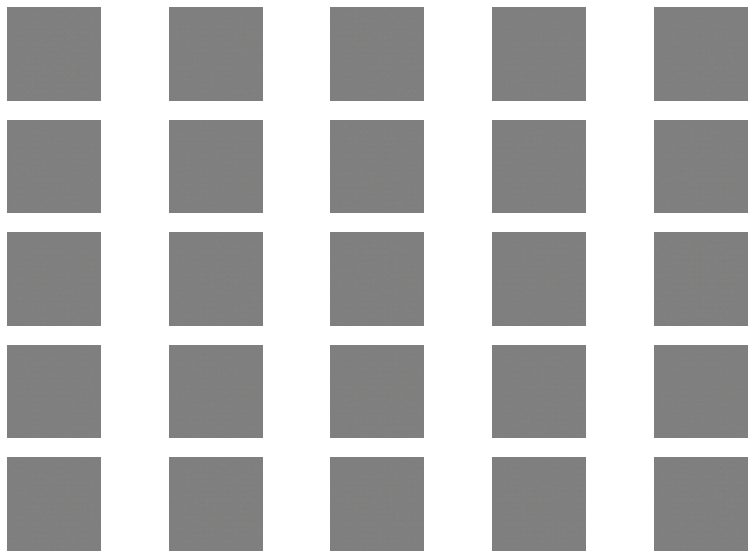

1 [D loss: 0.349090, acc.: 50.00%] [G loss: 0.619910]
2 [D loss: 0.352951, acc.: 50.00%] [G loss: 0.514544]
3 [D loss: 0.361582, acc.: 50.00%] [G loss: 0.377660]
4 [D loss: 0.374501, acc.: 50.00%] [G loss: 0.249293]
5 [D loss: 0.391385, acc.: 50.00%] [G loss: 0.196863]
6 [D loss: 0.404101, acc.: 50.00%] [G loss: 0.169137]
7 [D loss: 0.424355, acc.: 50.00%] [G loss: 0.163164]
8 [D loss: 0.430538, acc.: 50.00%] [G loss: 0.157257]
9 [D loss: 0.438770, acc.: 50.00%] [G loss: 0.166398]
10 [D loss: 0.444439, acc.: 50.00%] [G loss: 0.175521]
11 [D loss: 0.437522, acc.: 50.00%] [G loss: 0.167413]
12 [D loss: 0.430826, acc.: 50.00%] [G loss: 0.181251]
13 [D loss: 0.434418, acc.: 50.00%] [G loss: 0.182044]
14 [D loss: 0.438337, acc.: 50.00%] [G loss: 0.185708]
15 [D loss: 0.436885, acc.: 50.00%] [G loss: 0.194126]
16 [D loss: 0.427925, acc.: 50.00%] [G loss: 0.197346]
17 [D loss: 0.422365, acc.: 50.00%] [G loss: 0.211606]
18 [D loss: 0.427179, acc.: 50.00%] [G loss: 0.227898]
19 [D loss: 0.42553

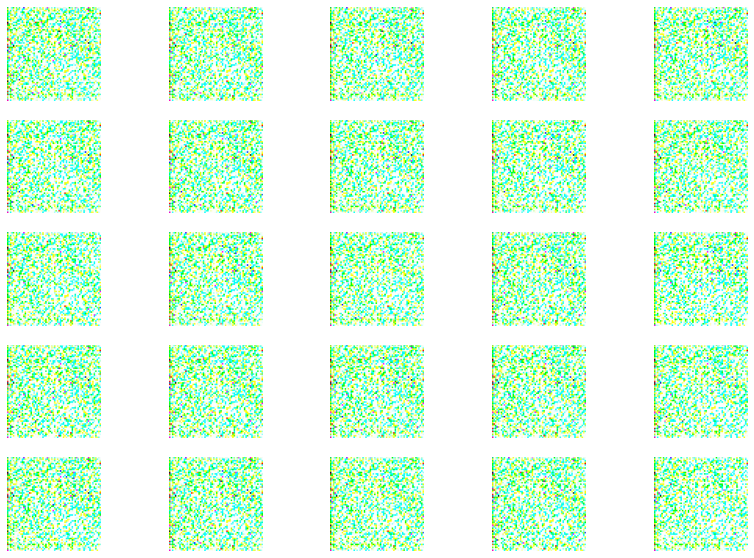

1001 [D loss: 0.000271, acc.: 100.00%] [G loss: 7.421893]
1002 [D loss: 0.000289, acc.: 100.00%] [G loss: 7.439436]
1003 [D loss: 0.000268, acc.: 100.00%] [G loss: 7.442403]
1004 [D loss: 0.000292, acc.: 100.00%] [G loss: 7.550240]
1005 [D loss: 0.000274, acc.: 100.00%] [G loss: 7.525409]
1006 [D loss: 0.000290, acc.: 100.00%] [G loss: 7.483677]
1007 [D loss: 0.000261, acc.: 100.00%] [G loss: 7.502824]
1008 [D loss: 0.000279, acc.: 100.00%] [G loss: 7.517483]
1009 [D loss: 0.000267, acc.: 100.00%] [G loss: 7.518127]
1010 [D loss: 0.000271, acc.: 100.00%] [G loss: 7.591491]
1011 [D loss: 0.000299, acc.: 100.00%] [G loss: 7.504220]
1012 [D loss: 0.000242, acc.: 100.00%] [G loss: 7.610198]
1013 [D loss: 0.000257, acc.: 100.00%] [G loss: 7.601748]
1014 [D loss: 0.000250, acc.: 100.00%] [G loss: 7.582720]
1015 [D loss: 0.000258, acc.: 100.00%] [G loss: 7.570268]
1016 [D loss: 0.000284, acc.: 100.00%] [G loss: 7.553640]
1017 [D loss: 0.000256, acc.: 100.00%] [G loss: 7.592851]
1018 [D loss: 

KeyboardInterrupt: ignored

In [ ]:
for i in range(5): 
  train(epochs=10000, batch_size=32, save_interval=1000)